In [4]:
import numpy as np
import pandas as pd
import warnings

import matplotlib.pyplot as plt
import seaborn as sns

# Importing the Bloomberg AIP using the blp module
from blp import blp

# Connect to the bloomberg API - You must be logged into the terminal for 
# this step to run as it connects to the Bloomberg localhost server
bquery = blp.BlpQuery().start()

# FINC305 Bloomberg Currency Analysis
I understand this is not a normal way of accessing bloomberg but I wanted to use this assignment as an opporiuntiy to learn how to apply my learnings from data-science courses to finincial analysis

### Steps to run code
1) Login to Bloomberg terminal
2) Create conda environment
   - Open Anaconda navigator and create an enviroment called `MNC` 
   - install the following packages: `pandas`, `matplotlib`, `seaborn`, `jupyterlab`, and `blp` - you will have to add the `conda-forge` channel to find blp
3) Launch JuypterLab from Anaconda Navigator
4) Run the cells one at a time

### Helper Functions that can be reused for each part of the analysis



In [5]:
# Helper Functions

def get_intraday_ticker_data(ticker, start_datetime, end_datetime, interval=1, event_type="TRADE"):
    data = bquery.bdib(ticker, interval=interval, event_type=event_type, start_datetime=start_datetime, end_datetime=end_datetime)
    data = pd.DataFrame(data)

    return data

def get_multiple_intraday_ticker_data(tickers, start_date, end_date, interval=1, event_type="TRADE"):
    df = pd.DataFrame()
    for ticker in tickers:
        single_ticker_res = get_intraday_ticker_data(ticker, start_date, end_date, interval, event_type)
        if df.empty:
            df = single_ticker_res.copy()[["time", "close"]]
            df.columns = ["time", ticker]
        else:
            df = df.merge(single_ticker_res[["time", "close"]], on="time", how="outer")
        
        df.rename(columns={"close": ticker}, inplace=True)
    return df

def get_historical_ticker_data(tickers, start_date, end_date):
    data = bquery.bdh(tickers, ['PX_LAST'], start_date=start_date, end_date=end_date)
    data = data.pivot_table(index='date', columns='security', values='PX_LAST')

    return data

def plot_data(data, title, tickers, loc='lower right'):
    warnings.simplefilter(action='ignore', category=FutureWarning)
    fig, ax1 = plt.subplots(figsize=(12, 6))

    sns.lineplot(data=data[tickers[0]], ax=ax1, label=tickers[0], color='blue')
    ax1.set_ylabel(tickers[0])
    if len(tickers) > 1:
        ax2 = ax1.twinx()
        sns.lineplot(data=data[tickers[1]], ax=ax2, label=tickers[1], color='green')  # Removed label for INR
        ax2.set_ylabel(tickers[1])
        ax2.legend().set_visible(False)

        lines, labels = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax1.legend(lines + lines2, labels + labels2, loc=loc)  # Combined legend for both axes

    plt.title(title)

    arr_size = len(data['time'])
    num_elements = 6
    index_spacing = arr_size // (num_elements - 1)

    selected_elements = []
    selected_indices = []

    for i in range(0, arr_size, index_spacing):
        selected_elements.append(data['time'][i])
        selected_indices.append(i)

    if len(selected_elements) < num_elements:
        selected_elements.append(data['time'].iloc[-1])
        selected_indices.append(arr_size - 1)

    ax1.set_xticks(selected_indices)
    ax1.set_xticklabels(selected_elements)
    ax1.set_xlabel('Time')

    plt.savefig('./plots/%s.png' % title.replace(' ', '_'), bbox_inches='tight')
    plt.show()

def get_stats(data, tickers):

    stats = pd.DataFrame(columns=["median", "std", "min", "max", "percentage_change", "mean_returns", "std_returns"])
    for ticker in tickers:
        non_nan_values = data[ticker].dropna()
        if len(non_nan_values) >= 2:
            first_non_nan = non_nan_values.iloc[0]
            last_non_nan = non_nan_values.iloc[-1]
            percentage_change = (last_non_nan - first_non_nan) / first_non_nan * 100
        else:
            percentage_change = np.nan

        for i in range(1, len(non_nan_values)):
            if i != 0:
                non_nan_values.iloc[i-1] = (non_nan_values.iloc[i] - non_nan_values.iloc[i - 1]) / non_nan_values.iloc[i - 1] * 100
        
        stats.loc[ticker] = [data[ticker].median(), 
                             data[ticker].std(), 
                             data[ticker].min(), 
                             data[ticker].max(), 
                             percentage_change,
                             non_nan_values.mean(),
                             non_nan_values.std()]
    return stats


def get_plot_title(tickers):
    title = ''
    for i in range(len(tickers)):
        if i == len(tickers) - 1 and i != 0:
            title  = title + ' and '
        elif i != 0:
            title  = title + ', '
        title  = title + tickers[i].split(' ')[0]

    return title


## One Month Movements
This code used the Bloomberg Pipes API to retive the data for th GDP/INR cross rate and performs analysis on it

,median,std,min,max,percentage_change,mean_returns,std_returns
CNYINR Curncy,11.5300,0.026070,11.4950,11.5910,-0.017307,0.035835,0.644888
CNY Curncy,7.2389,0.010841,7.2037,7.2473,-0.153357,0.023350,0.416392


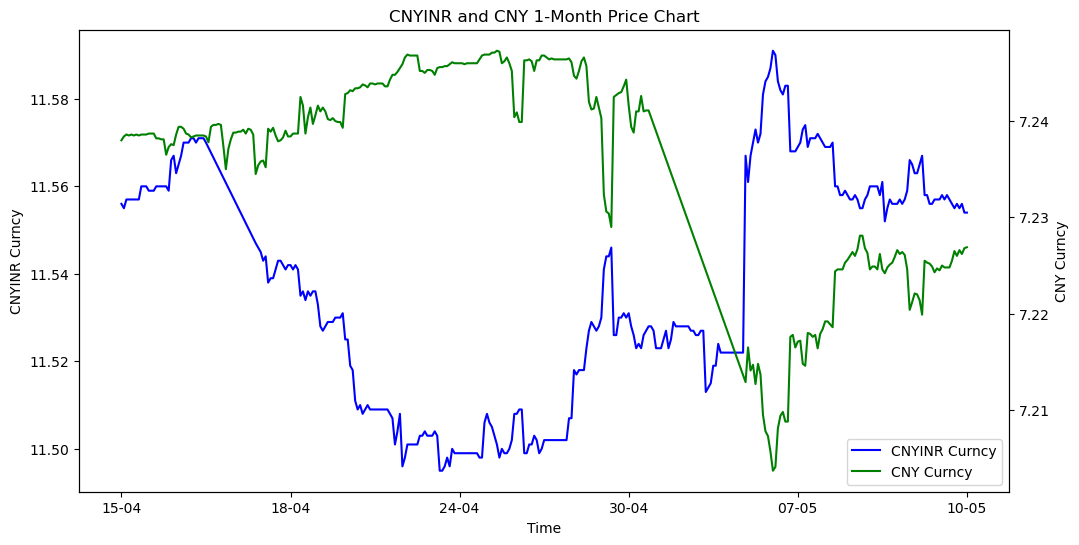

In [6]:
tickers = ['CNYINR Curncy', 'CNY Curncy']
start_date = "2024-04-13"
end_date = "2024-05-13"
interval = 60
event_type = "TRADE"

one_month = get_multiple_intraday_ticker_data(tickers, start_date, end_date, interval, event_type)

one_month['time'] = one_month['time'].dt.strftime('%d-%m')

title = get_plot_title(tickers)

display(get_stats(one_month, tickers))
plot_data(one_month, '%s 1-Month Price Chart' % title, tickers)


## Three-Month Movements

,median,std,min,max,percentage_change,mean_returns,std_returns
CNYINR Curncy,11.5330,0.026397,11.4950,11.6170,0.121317,0.023522,0.524063
CNY Curncy,7.2186,0.020604,7.1741,7.2473,0.434988,0.015578,0.328000


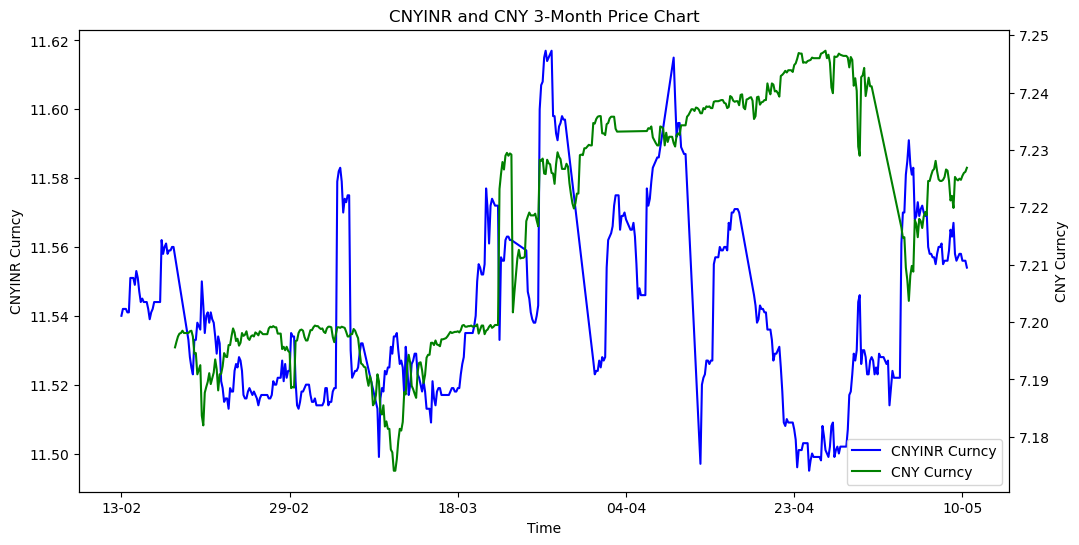

In [7]:
start_date = "2024-02-13"
end_date = "2024-05-13"
interval = 120
event_type = "TRADE"

three_month = get_multiple_intraday_ticker_data(tickers, start_date, end_date, interval, event_type)

three_month['time'] = three_month['time'].dt.strftime('%d-%m')

title = get_plot_title(tickers)
display(get_stats(three_month, tickers))
# display(three_month.head(n=40))
plot_data(three_month, '%s 3-Month Price Chart' % title, tickers)


## One Year Movements  

,median,std,min,max,percentage_change,mean_returns,std_returns
CNYINR Curncy,11.5260,0.111641,11.2950,11.8400,-2.474662,0.038024,0.810144
CNY Curncy,7.1979,0.071115,6.9517,7.3439,4.052246,0.046564,0.516685


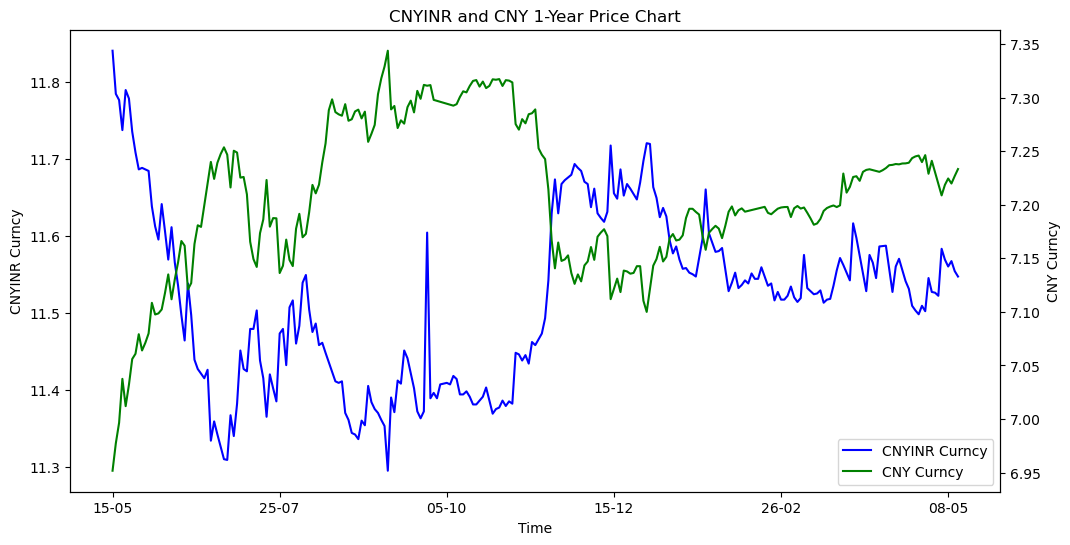

In [8]:
start_date = "20230513"
end_date = "20240513"

one_year = get_historical_ticker_data(tickers, start_date, end_date)
one_year.reset_index(inplace=True)
one_year.rename(columns={'date': 'time'}, inplace=True)
one_year['time'] = one_year['time'].dt.strftime('%d-%m')


title = get_plot_title(tickers)
display(get_stats(one_year, tickers))

plot_data(one_year, '%s 1-Year Price Chart' % title , tickers)


# Five Year Movements

,median,std,min,max,percentage_change,mean_returns,std_returns
CNYINR Curncy,11.42700,0.601454,9.9070,12.2090,12.766995,0.019768,0.484248
CNY Curncy,6.90915,0.302623,6.3092,7.3439,5.190161,0.010485,0.352365


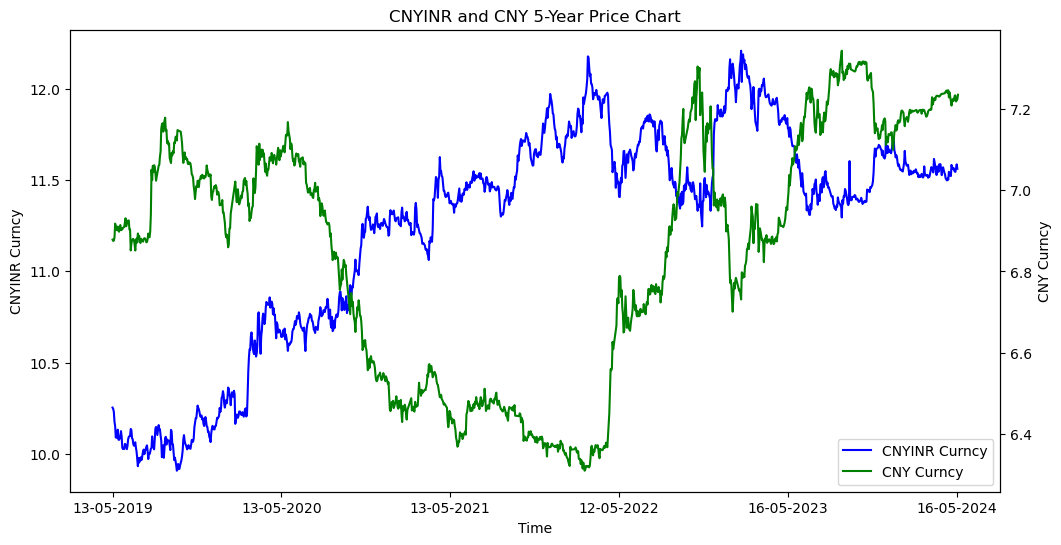

In [9]:
end_date = "20290513"
start_date = "20190513"

tickers = ['CNYINR Curncy', 'CNY Curncy']

five_year = get_historical_ticker_data(tickers, start_date, end_date)
five_year.reset_index(inplace=True)
five_year.rename(columns={'date': 'time'}, inplace=True)
five_year['time'] = five_year['time'].dt.strftime('%d-%m-%Y')

title = get_plot_title(tickers)
display(get_stats(five_year, tickers))
plot_data(five_year, '%s 5-Year Price Chart' % title, tickers, 'lower right')

,median,std,min,max,percentage_change,mean_returns,std_returns
INR Curncy,75.43060,4.568660,68.4175,83.5437,18.143475,0.082664,2.406927
CNY Curncy,6.90915,0.302623,6.3092,7.3439,5.190161,0.010485,0.352365


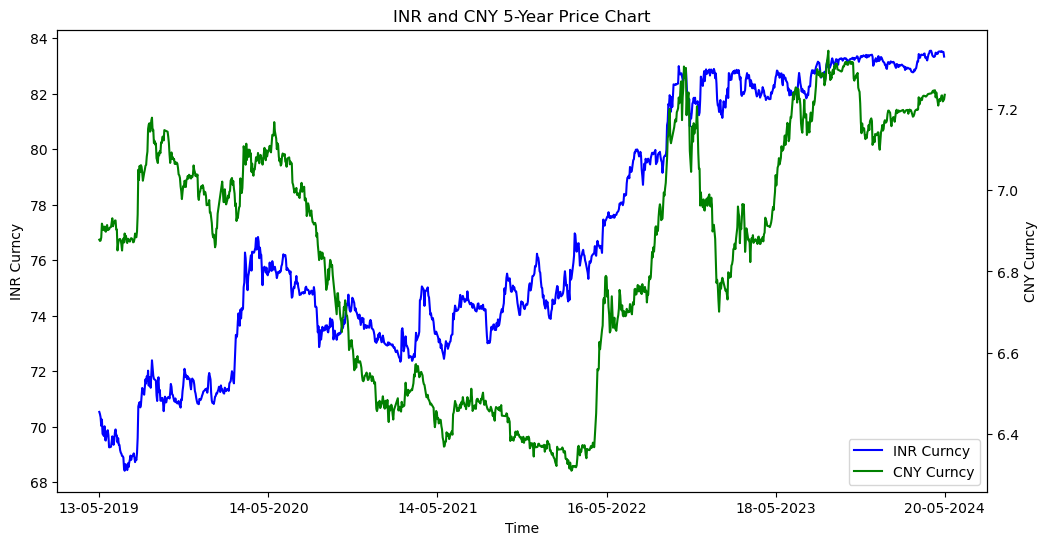

In [10]:
end_date = "20290513"
start_date = "20190513"

tickers = ['INR Curncy', 'CNY Curncy']

five_year = get_historical_ticker_data(tickers, start_date, end_date)
five_year.reset_index(inplace=True)
five_year.rename(columns={'date': 'time'}, inplace=True)
five_year['time'] = five_year['time'].dt.strftime('%d-%m-%Y')

title = get_plot_title(tickers)
display(get_stats(five_year, tickers))
plot_data(five_year, '%s 5-Year Price Chart' % title, tickers, 'lower right')